In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import rq

cv2.destroyAllWindows()

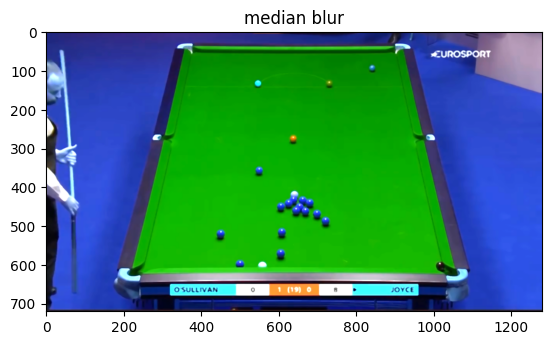

In [22]:
image_path = 'reference_frame.png'  

image = cv2.imread(image_path)

# make all color more pure and more contrast
# This make more clear edges

def custom_median_blur(image, kernel_size):
    padded_image = np.pad(image, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0, 0)), mode='reflect')
    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                result[i, j, k] = np.median(padded_image[i:i+kernel_size, j:j+kernel_size, k])
    return result

def custom_convert_scale_abs(image, alpha, beta):
    result = alpha * image + beta
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

image = custom_median_blur(image, 5)
image = custom_convert_scale_abs(image, 1.5, 0)

plt.imshow(image)
plt.title('median blur')
plt.show()

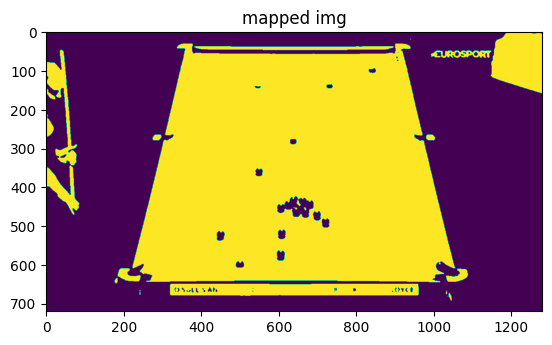

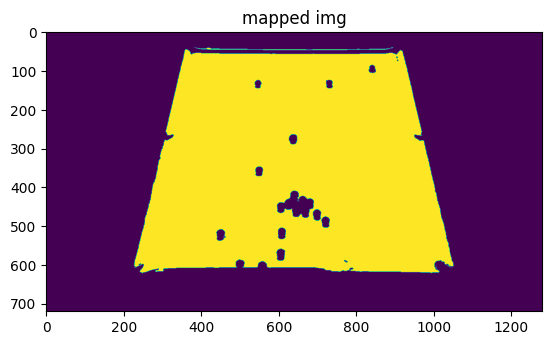

In [23]:
# now map to gray scale but only with 2 colors
# more blue more black more green more white
def map_to_gray(image):
    avg_color = np.mean(image, axis=(0, 1))
    threshold = avg_color[1]
    gray_mapped = np.where(image[..., 1] > threshold, 255, 0)
    return gray_mapped.astype(np.uint8)

# map to gray in proportion to the green channel, more green more white
def map_to_gray2(image):
    # Compute the average value for each color channel
    avg_red = np.mean(image[:, :, 0])
    avg_green = np.mean(image[:, :, 1])
    avg_blue = np.mean(image[:, :, 2])

    # Create a mask where green is higher than average and red and blue are below their averages
    mask = (image[:, :, 1] > avg_green) & (image[:, :, 0] < avg_red) & (image[:, :, 2] < avg_blue)

    # Apply the mask to set selected pixels to white, others to black
    gray_mapped = np.where(mask, 255, 0)

    # Return the resulting image
    return gray_mapped.astype(np.uint8)


image_2 = image.copy()
image_2 = map_to_gray(image_2)

plt.imshow(image_2)
plt.title('mapped img')
plt.show()


image = map_to_gray2(image)
plt.imshow(image)
plt.title('mapped img')
plt.show()




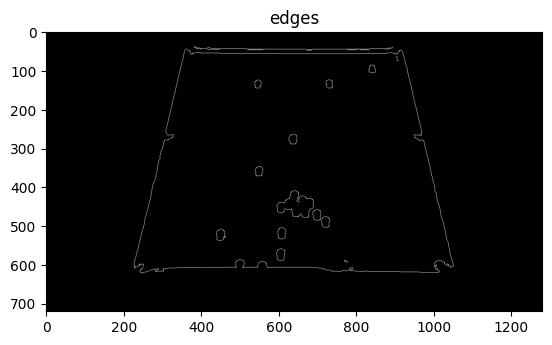

In [24]:
from scipy.ndimage import convolve

# find edge with  cv2.Canny and plot
edges = cv2.Canny(image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title('edges')
plt.show()

In [25]:
## ####################################
## ########## SOBEL FILTERS ###########
## ########## HOUGH LINES  ############
## ####################################

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = np.clip(G / G.max() * 255, 0, 255) 
    theta = np.arctan2(Iy, Ix)
    
    return G, theta


def hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution):
    height, width = edges.shape
    diagonal = np.sqrt(height**2 + width**2)

    theta_angles = np.arange(min_theta, max_theta, theta_resolution)
    rho_values = np.linspace(-diagonal, diagonal, int(2 * diagonal / rho_resolution) + 1)

    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros((num_rhos, num_thetas))

    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)

    y_idxs, x_idxs = np.where(edges > 0)

    for x, y in zip(x_idxs, y_idxs):
        for idx in range(num_thetas):

            rho = x * coss[idx] + y * sins[idx]
            rho_index = np.argmin(np.abs(rho_values - rho))
            accumulator[rho_index, idx] += 1

    idx_rhos, idx_thetas = np.where(accumulator > threshold)
    final_rhos = rho_values[idx_rhos]
    final_thetas = theta_angles[idx_thetas]

    polar_coordinates = np.column_stack((final_rhos, final_thetas))
    return polar_coordinates



G, theta = sobel_filters(image)

rho_resolution = 1
theta_resolution = np.pi / 180
min_theta = 0
max_theta = np.pi
threshold = 100 


In [26]:
## ####################################
## #####SPLIT VERTICAL AND HORIZ ######
## ####################################

# select only vertical lines
def filter_vertical_lines(lines, angle_threshold_deg):
    vertical_lines = []
    horizonal_lines = []
    angle_threshold_rad = np.radians(angle_threshold_deg)
    min_theta = np.pi/2 - angle_threshold_rad
    max_theta = np.pi/2 + angle_threshold_rad
    vertical_lines = [line for line in lines if min_theta <= line[1] <= max_theta]
    horizonal_lines = [line for line in lines if min_theta > line[1] or line[1] > max_theta]
    return np.array(vertical_lines), np.array(horizonal_lines)

lines = hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution)
horizontal_lines , veritcal_line= filter_vertical_lines(lines, 20)

all_lines = np.concatenate((horizontal_lines, veritcal_line), axis=0)

def adjust_lines_to_horizontal(lines):
    adjusted_lines = []
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        new_rho = y0 
        adjusted_lines.append((new_rho, np.pi / 2))
        
    return np.array(adjusted_lines)

horizontal_lines = adjust_lines_to_horizontal(horizontal_lines)

In [27]:
## ####################################
#  ##### FILTER TO GET ONLY 4 LINES ###
## ####################################
# get the horizontal line that have  min y at x = 0
# get the horizontal line that have  max y at x = 0

def get_min_max_y_horizontal_lines(lines):
    min_y = np.inf
    max_y = -np.inf
    min_y_line = None
    max_y_line = None
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        if y0 < min_y:
            min_y = y0
            min_y_line = (rho, theta)
        if y0 > max_y:
            max_y = y0
            max_y_line = (rho, theta)
    return min_y_line, max_y_line

min_y_line, max_y_line = get_min_max_y_horizontal_lines(horizontal_lines)
horizontal_lines = np.array([min_y_line, max_y_line])

# get the vertical line that have  min x at y = 0
# get the vertical line that have  max x at y = 0

def get_min_max_x_vertical_lines(lines):
    min_x = np.inf
    max_x = -np.inf
    min_x_line = None
    max_x_line = None
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        if x0 < min_x:
            min_x = x0
            min_x_line = (rho, theta)
        if x0 > max_x:
            max_x = x0
            max_x_line = (rho, theta)
    return min_x_line, max_x_line

min_x_line, max_x_line = get_min_max_x_vertical_lines(veritcal_line)
veritcal_line = np.array([min_x_line, max_x_line])


# merge lines
lines = np.concatenate((horizontal_lines, veritcal_line), axis=0)







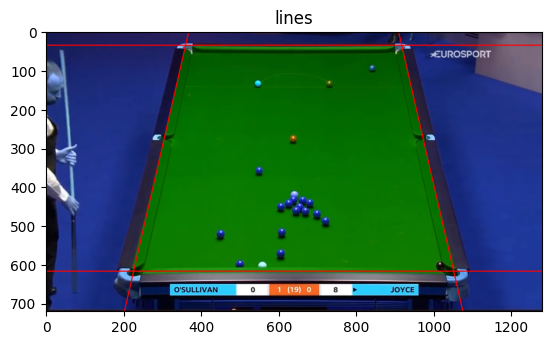

In [28]:
## ####################################
## ########         PLOT         ######
## ####################################
image_real = cv2.imread(image_path)

def plot_lines(image, lines, size_line=3000):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + size_line * (-b))
        y1 = int(y0 + size_line * (a))
        x2 = int(x0 - size_line * (-b))
        y2 = int(y0 - size_line * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plot_lines(image_real, lines)
plt.imshow(image_real)
plt.title('lines')
plt.show()


## ####################################
## ####################################
## ####################################

# adjust all orizonal 


Intersection Point 1: (225.38, 617.54)
Intersection Point 2: (359.53, 36.50)
Intersection Point 3: (918.31, 36.50)
Intersection Point 4: (1052.45, 617.54)


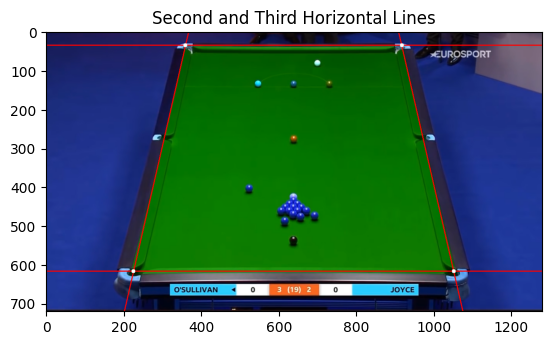

In [29]:
# COMPUTE INTERSECTION POINTS



# Compute intersection points
# every line is defined ρ = x * cos(θ) + y * sin(θ)
# so we can write it as A * x = b
# our system is A x = b
# | cos(θ1) sin(θ1) | x | =  | ρ1 |
# | cos(θ2) sin(θ2) | y |  = | ρ2 |

intersection_points = []
for rho1, theta1 in horizontal_lines:
    for rho2, theta2 in veritcal_line:
        A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
        b = np.array([rho1, rho2])
        intersection_point = np.linalg.solve(A, b)
        intersection_points.append(intersection_point)

# Sort point to manage more easily
intersection_points.sort(key=lambda x: x[0])
intersection_points_pos = []



## #################################
## #################################

image_path = 'test_image.PNG'  

output_image = cv2.imread(image_path)

# JUST VISUALIZATION
# PLOT LINES AND INTERSECTION POINTS
plot_lines(output_image, lines)

i = 0
for intersection_point in intersection_points:
    x, y = intersection_point
    print(f'Intersection Point {i + 1}: ({x:.2f}, {y:.2f})')
    intersection_points_pos.append((x, y))
    cv2.circle(output_image, (int(x), int(y)), 5, (255, 255, 255), -1)
    i += 1


plt.imshow(output_image)
plt.title('Second and Third Horizontal Lines')
plt.show()

## #################################
## #################################


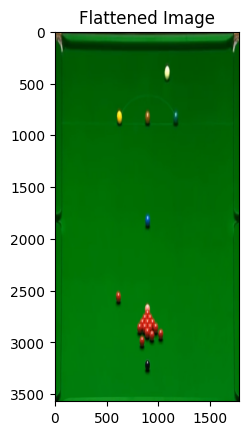

In [30]:
# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF INTERSECTION POINTS ARE CORRECT

cv2.destroyAllWindows()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)

A = (A[0] * 1000, A[1] * 1000)
B = (B[0] * 1000, B[1] * 1000)
C = (C[0] * 1000, C[1] * 1000)
D = (D[0] * 1000, D[1] * 1000)

pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)

# build the transformation matrix without cv2.getPerspectiveTransform
def find_prespective_transform(pts1, pts2):
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = pts1[i]
        u, v = pts2[i]
        A[i * 2] = [x, y, 1, 0, 0, 0, -u * x, -u * y, -u]
        A[i * 2 + 1] = [0, 0, 0, x, y, 1, -v * x, -v * y, -v]
    U, S, V = np.linalg.svd(A)
    M = V[-1].reshape(3, 3)
    return M



from PIL import Image

def manual_warp_perspective(image_in, M, out_h, out_w):
    image = image_in.copy()

    output_image = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    
    M_inv = np.linalg.inv(M)
    height, width, _ = image.shape

    for y in range(out_h):
        for x in range(out_w):

            # STEP 1 get homogeneous coordinates
            output_coords = np.array([x, y, 1])

            # STEP 2 apply inverse transformation + normalization
            input_coords = M_inv.dot(output_coords)
            input_coords /= input_coords[2] 

            # STEP 3 add into the final image
            x_in, y_in = int(input_coords[0]), int(input_coords[1])
            output_image[y, x] = image[y_in, x_in]

    return output_image


M_visiva = find_prespective_transform(pts2, pts1)


cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_real = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_img = manual_warp_perspective(image_real, M_visiva, 3569, 1778)
plt.imshow(out_img)
plt.title('Flattened Image')
plt.show()

# #################################
# #################################
# #################################



# compute projective transformation

A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)


pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)

M = find_prespective_transform(pts2, pts1)
M_inv = np.linalg.inv(M)




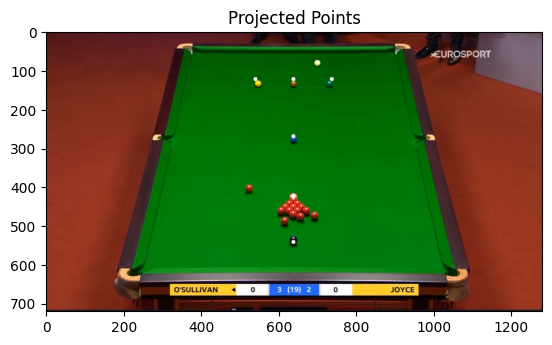

In [31]:
# COMPUTE THE BALL POSITION AND DRAW IT

# first some variable
middle_y = 3.569/2
middle_x = 1.778/2

# (yellow, green, brown, blue, pink, black
points = np.array([
    [middle_x - 0.292, middle_y - 1.0475],  # yellow
    [middle_x + 0.292, middle_y - 1.0475],  # green
    [middle_x, middle_y - 1.0475],          # brown
    [middle_x, middle_y],                   # blue
    [middle_x, middle_y + 0.89225],         # pink
    [middle_x, middle_y + 1.4605]           # black
])


# Apply transformation 

# Like for image but with points
def apply_transformation_to_points(points, M):
    transformed_points = []
    for point in points:
        point_homog = np.array([point[0], point[1], 1])
        transformed_point = np.dot(np.linalg.inv(M), point_homog) 
        transformed_point /= transformed_point[2] 
        transformed_points.append(transformed_point[:2])
    return np.array(transformed_points)

projected_points = apply_transformation_to_points(points, M)


# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF BALLS ARE CORRECT

cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# draw points
output_image = image_rgb.copy()
for point in projected_points:

    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)


# show image
plt.imshow(output_image)
plt.title('Projected Points')
plt.show()

# #################################
# #################################
# #################################


(918.3095154317459, 36.497044815677846) (359.5302683794029, 36.49704481567788)
(1052.4547887192662, 617.5440597098257) (225.38499509188287, 617.5440597098257)
Area of the table: 402621.72 px^2
Corner Points:
Point 1: (225.38, 617.54)
Point 2: (359.53, 36.50)
Point 3: (918.31, 36.50)
Point 4: (1052.45, 617.54)


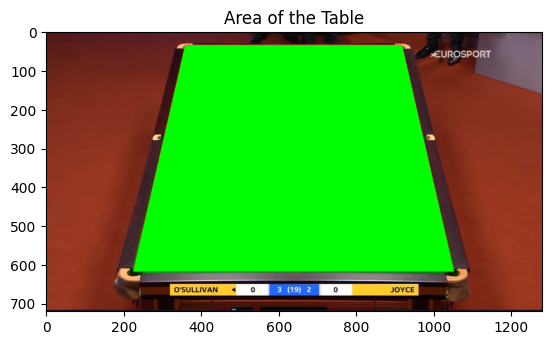

Area of the table: 6.35 m^2
error:  1.4416503901770739e-07


In [32]:
# AREA OF TABLE

# GET THE AREA OF THE TABLE

print(intersection_points_pos[2],intersection_points_pos[1])
print(intersection_points_pos[3],intersection_points_pos[0])
Base_a = intersection_points_pos[2][0]-intersection_points_pos[1][0]
Base_b = intersection_points_pos[3][0]-intersection_points_pos[0][0]
Height = intersection_points_pos[0][1]-intersection_points_pos[1][1]
Area = (Base_a+Base_b)*Height/2
Area_in_px = Area

print(f'Area of the table: {Area:.2f} px^2')

# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF AREA IS CORRECT
print('Corner Points:')
for i, point in enumerate(intersection_points_pos):
    print(f'Point {i + 1}: ({point[0]:.2f}, {point[1]:.2f})')

output_image = image_rgb.copy()
for i in range(4):
    cv2.line(output_image, (int(intersection_points_pos[i][0]), int(intersection_points_pos[i][1])), (int(intersection_points_pos[(i + 1) % 4][0]), int(intersection_points_pos[(i + 1) % 4][1])), (255, 0, 0), 2)
    cv2.fillPoly(output_image, np.array([intersection_points_pos], dtype=np.int32), (0, 255, 0, 100))

plt.imshow(output_image)
plt.title('Area of the Table')
plt.show()

# #################################
# #################################


# double check transoform intersection_points_pos with M into normalized coordinates and compute area

# use M convert intersection_points_pos into normalized coordinates
normalized_points = cv2.perspectiveTransform(np.array([intersection_points_pos], dtype=np.float32), M)
# compute the area
Base_a = normalized_points[0][2][0]-normalized_points[0][1][0]
Base_b = normalized_points[0][3][0]-normalized_points[0][0][0]
Height = normalized_points[0][0][1]-normalized_points[0][1][1]
Area = (Base_a+Base_b)*Height/2
print(f'Area of the table: {Area:.2f} m^2')
print("error: ", Area - 3.569*1.778)






In [39]:
import numpy as np
from scipy.linalg import rq
from numpy.linalg import svd


# ASSUMPTIONS corner top left is (0,0.8,0)                OR  camera see approx
# our table is 
#   (0, 0)              (1.778, 0)                    (226  614)               (638 452)
#     |  _________________  |                              /----------------------\
#     |                     |                             /                        \
#     |                     |                            /                          \
#     |                     |                           /                            \
#     |                     |                          /                              \
#     |                     |                         /                                \
#     |                     |                        /                                  \
#     |                     |                       /___________________________________ \
#     |                     |                   (360  33)                               (917 33)
#     |                     | 
#     |  __________________ | 
#   (0, 3.569)      (1.778, 3.569)


points_chosen = []

A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)
middle_y = 3.569/2
middle_x = 1.778/2

points_chosen = np.array([
    A,
    B,
    C,
    D,
    [middle_x - 0.292, middle_y - 1.0475],  # yellow
    [middle_x + 0.292, middle_y - 1.0475],  # green
    [middle_x, middle_y - 1.0475],          # brown
    [middle_x, middle_y],                   # blue
    [middle_x, middle_y + 0.89225],         # pink
    [middle_x, middle_y + 1.4605]           # black
])

# build first 3D points (World coordinates)
numeber_of_points = points_chosen.shape[0]
points_3D = np.ones((numeber_of_points, 3))
points_3D *= 0.75
points_3D[:, :2] = points_chosen



# GET THE 2D POINTS (Image coordinates)
projected_points = apply_transformation_to_points(points_chosen , M)

# prepare point 3D in homogeneous
points_3D_hom = np.ones((numeber_of_points, 4))
points_3D_hom[:, :3] = points_3D


# flip y axis 
projected_points[:, 1] = image.shape[0] - projected_points[:, 1]
points_3D_hom[:, 1] = 3.569 - points_3D_hom[:, 1]
# flip x axis 2d
# projected_points[:, 0] = image.shape[1] - projected_points[:, 0]

# projected_points[:, 0] = projected_points[:, 0]- image.shape[1]/2 
# projected_points[:, 1] = projected_points[:, 1]- image.shape[0]/2 


print("point 2D to 3D")
print(projected_points[0])
print(points_3D_hom[0])
print(projected_points[1])
print(points_3D_hom[1])









point 2D to 3D
[225.38499832 102.45594914]
[-0.889  -1.7845  0.      1.    ]
[359.53027344 683.50295639]
[-0.889   1.7845  0.      1.    ]


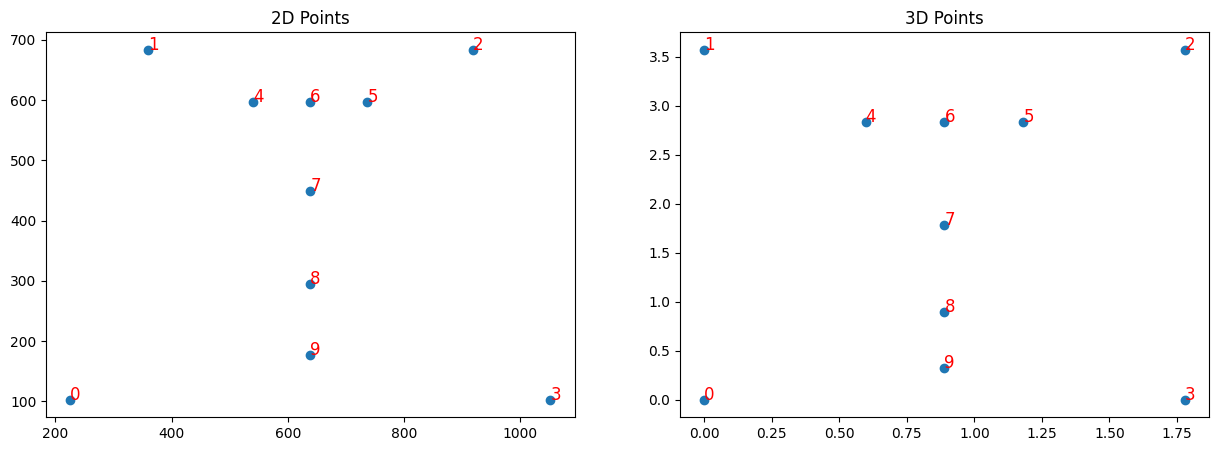

Calibration matrix K: [[ 0.07957779  0.01470437 -0.0327173 ]
 [ 0.          0.04358178  0.80284498]
 [ 0.          0.          0.01053172]]
Rotation matrix R: [[ 1.00000000e+00  8.37984806e-14  8.65619864e-17]
 [-8.37985147e-14  9.99999861e-01  5.28074435e-04]
 [ 4.23101391e-17  5.28074435e-04 -9.99999861e-01]]
Camera center C: [-0.35159167 -0.68521841  0.76536474]


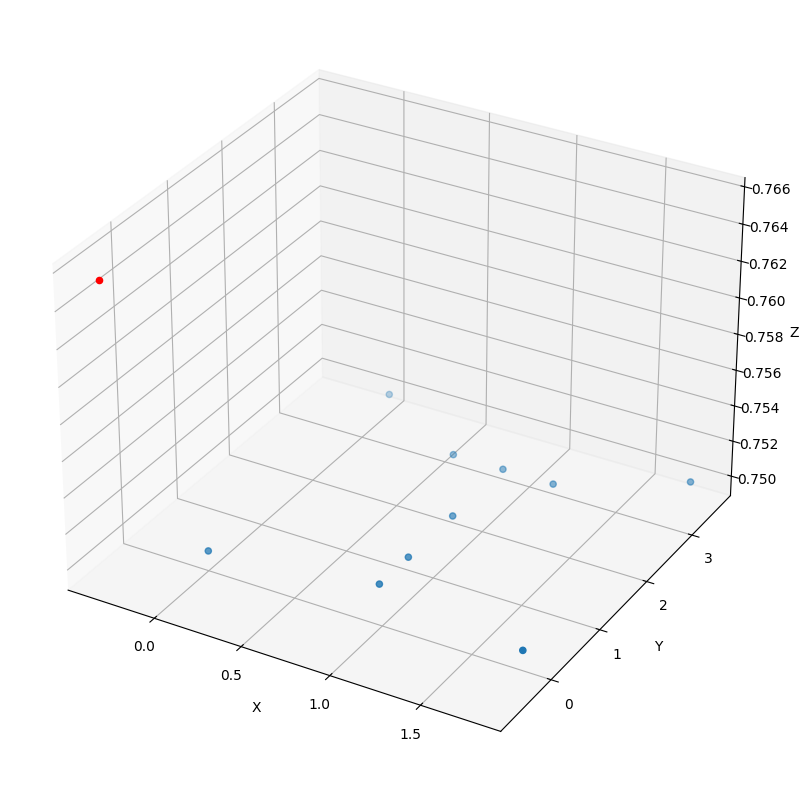

[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [42]:
# plot two figure next to each other using only plotlib
# first plot the points 2d and second 3d plot. each point labeled with the index
# 3d plot is just a scatter plot

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(projected_points[:, 0], projected_points[:, 1])
axs[0].set_title('2D Points')
for i, point in enumerate(projected_points):
    axs[0].text(point[0], point[1], str(i), fontsize=12, color='red')
axs[1].scatter(points_3D_hom[:, 0], points_3D_hom[:, 1])
axs[1].set_title('3D Points')
for i, point in enumerate(points_3D_hom):
    axs[1].text(point[0], point[1], str(i), fontsize=12, color='red')
plt.show()

In [40]:
from scipy.linalg import rq

# NOW we need to find camera matrix P
# we have 2D points and 3D points


# Costruzione della matrice A per DLT
num_points = points_3D_hom.shape[0]
A = np.zeros((2 * num_points, 12))

for i in range(num_points):
    X, Y, Z, W = points_3D_hom[i]
    u, v = projected_points[i]

    A[2*i] = [X, Y, Z, W, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u*W]
    A[2*i + 1] = [0, 0, 0, 0, X, Y, Z, W, -v*X, -v*Y, -v*Z, -v*W]

# Calcolo della SVD
U, S, V = svd(A)

# Estrazione della matrice di proiezione P dalla SVD
P = V[-1].reshape(3, 4)
P /= P[-1, -1]  # Normalizzazione

# Stampa della matrice di proiezione P
print("Matrice di Proiezione P:")
print(P)

# Estrazione delle matrici K (intrinseca) e R (rotazione) dalla matrice di proiezione
from scipy.linalg import rq

def decompose_projection_matrix(P):
    K, R = rq(P[:, :3])
    t = np.linalg.inv(K) @ P[:, 3]
    return K, R, t

K, R, t = decompose_projection_matrix(P)
camera_position = -R.T @ t

print('Posizione della Camera:')
print(camera_position[0], camera_position[1], camera_position[2])

# plot points in 3d and camera position anlso plot index of points make axis y from -9 to 20 and z from 0 to 10
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D_hom[:, 0], points_3D_hom[:, 1], points_3D_hom[:, 2])
ax.scatter(camera_position[0], camera_position[1], camera_position[2], c='r', s=100)
for i, point in enumerate(points_3D_hom):
    ax.text(point[0], point[1], point[2], str(i), fontsize=12, color='red')
ax.set_xlim(-9, 5)
ax.set_ylim(-9, 5)
ax.set_zlim(0, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# # recompute the 2d points from 3d points and camera matrix
# recomputed_points = (P @ points_3D_hom.T).T
# recomputed_points /= recomputed_points[:, 2, None]
# recomputed_points = recomputed_points[:, :2]

# # plot the recomputed points using plotlib
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# axs[0].scatter(projected_points[:, 0], projected_points[:, 1])
# axs[0].set_title('Original 2D Points')
# for i, point in enumerate(projected_points):
#     axs[0].text(point[0], point[1], str(i), fontsize=12, color='red')
# axs[1].scatter(recomputed_points[:, 0], recomputed_points[:, 1])
# axs[1].set_title('Recomputed 2D Points')
# for i, point in enumerate(recomputed_points):
#     axs[1].text(point[0], point[1], str(i), fontsize=12, color='red')
# plt.show()






Matrice di Proiezione P:
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan -inf  nan]]


/var/folders/0v/5dr3zfdx0mx5m4fsb3h_ksn40000gn/T/ipykernel_52909/3022990274.py:23: RuntimeWarning: divide by zero encountered in divide
  P /= P[-1, -1]  # Normalizzazione
/var/folders/0v/5dr3zfdx0mx5m4fsb3h_ksn40000gn/T/ipykernel_52909/3022990274.py:23: RuntimeWarning: invalid value encountered in divide
  P /= P[-1, -1]  # Normalizzazione


ValueError: array must not contain infs or NaNs

[-0.46386965 -0.11489834  0.74242834]
67.50172939253645 190.43455470812816


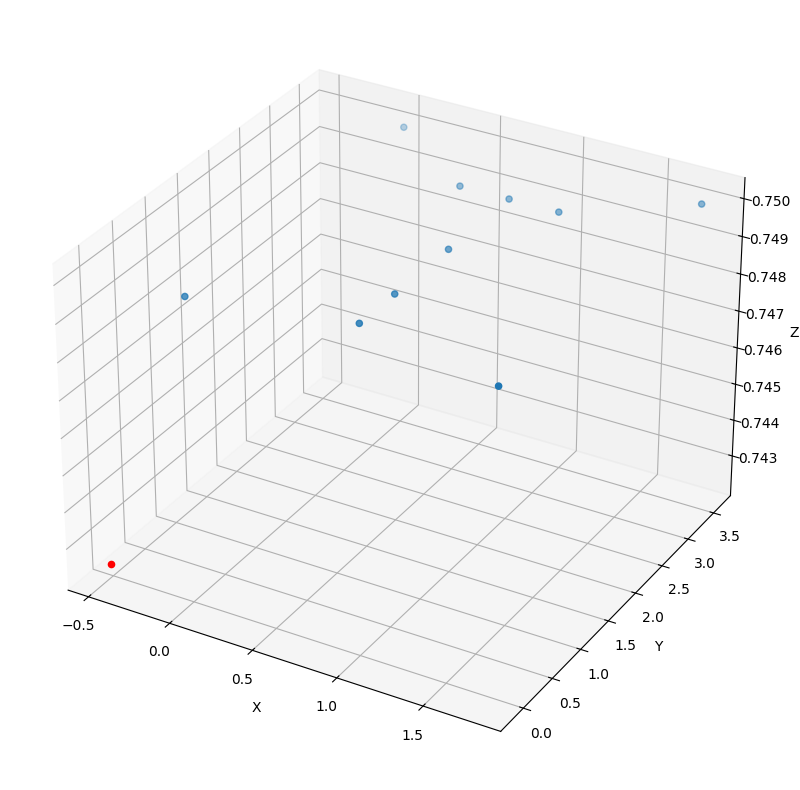

In [ ]:
from typing import Tuple

def DLT(X: np.ndarray, x: np.ndarray) -> np.ndarray:
    n_corr = X.shape[0]

    assert X.shape[0] == x.shape[0]

    A = np.zeros((2 * n_corr, 12))

    # fill up matrix A for each correspondence
    for i in range(n_corr):
        A[i * 2, 4:] = np.concatenate([
            -x[i, -1] * X[i],
            x[i, 1] * X[i]
        ])

        A[i * 2 + 1, :] = np.concatenate([
            x[i, -1] * X[i],
            np.zeros(4),
            -x[i, 0] * X[i]
        ])

    # could avoid SVD decomposition if rank is 11
    # rank = np.linalg.matrix_rank(A)

    _, _, vh = np.linalg.svd(A)
    # last column of V contains p that minimizes Ap = 0
    p = vh.T[:, -1]
    # reshape it into the projective matrix P
    P = p.reshape(3, 4)
    return P



def get_camera_parameters(P: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    M = P[:, :-1]

    # Get K and R with a RQ decomposition.
    # permutation matrix with 1s on the anti-diagonal
    permut = np.fliplr(np.eye(3))

    q, r = np.linalg.qr(M.T @ permut)

    # calibration matrix 
    K = permut @ r.T @ permut
    K /= K[-1, -1]
    # camera orientation 
    R = permut @ q.T

    C_tilde = np.linalg.inv(-M) @ P[:, -1]

    # make sure K has positive diagonal values and adapt R
    mask = np.diag(K) < 0
    R[mask, :] *= -1
    K[:, mask] *= -1

    # sanity check
    P_hat = K @ R @ (np.hstack([np.eye(3), (-C_tilde).reshape(-1, 1)]))
    P_hat_norm = P_hat / P_hat[-1, -1]
    P_norm = P / P[-1, -1]

    assert np.isclose(P_norm, P_hat_norm).all()

    return K, R, C_tilde
# homogeneous of projected points
points_2D_hom = np.ones((numeber_of_points, 3))
points_2D_hom[:, :2] = projected_points

P = DLT(points_3D_hom, points_2D_hom)
K, R, C_tilde = get_camera_parameters(P)

print(C_tilde)

# check map of point 0 0 0.8
point_3D = np.array([0. ,   3.569, 0.8, 1])
point_2D = P @ point_3D
point_2D /= point_2D[2]
print(point_2D[0], point_2D[1])


# plot points in 3d and camera position
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D_hom[:, 0], points_3D_hom[:, 1], points_3D_hom[:, 2])
ax.scatter(C_tilde[0], C_tilde[1], C_tilde[2], color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


Calibration matrix K: [[ 0.07957779  0.01470437 -0.0327173 ]
 [ 0.          0.04358178  0.80284498]
 [ 0.          0.          0.01053172]]
Rotation matrix R: [[ 1.00000000e+00  8.37984806e-14  8.65619864e-17]
 [-8.37985147e-14  9.99999861e-01  5.28074435e-04]
 [ 4.23101391e-17  5.28074435e-04 -9.99999861e-01]]
Camera center C: [-0.35159167 -0.68521841  0.76536474]


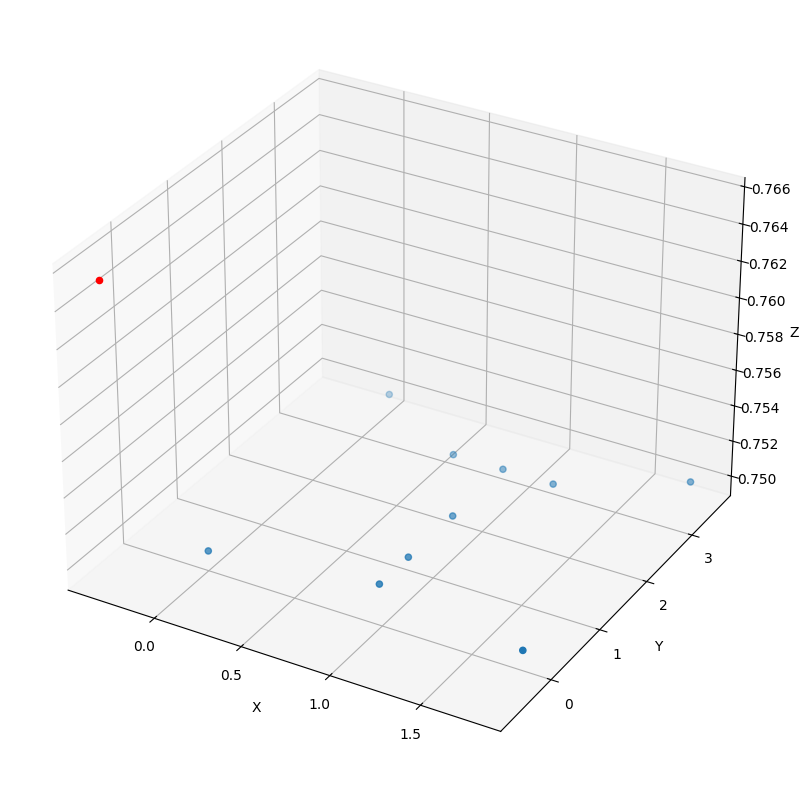

[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [41]:

points_chosen = []

A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)
middle_y = 3.569/2
middle_x = 1.778/2

points_chosen = np.array([
    A,
    B,
    C,
    D,
    [middle_x - 0.292, middle_y - 1.0475],  # yellow
    [middle_x + 0.292, middle_y - 1.0475],  # green
    [middle_x, middle_y - 1.0475],          # brown
    [middle_x, middle_y],                   # blue
    [middle_x, middle_y + 0.89225],         # pink
    [middle_x, middle_y + 1.4605]           # black
])

# build first 3D points (World coordinates)
numeber_of_points = points_chosen.shape[0]
points_3D = np.ones((numeber_of_points, 3))
points_3D *= 0.75
points_3D[:, :2] = points_chosen



# GET THE 2D POINTS (Image coordinates)
projected_points = apply_transformation_to_points(points_chosen , M)

# prepare point 3D in homogeneous
points_3D_hom = np.ones((numeber_of_points, 4))
points_3D_hom[:, :3] = points_3D


# flip y axis 
projected_points[:, 1] = image.shape[0] - projected_points[:, 1]
points_3D_hom[:, 1] = 3.569 - points_3D_hom[:, 1]

import numpy as np
from numpy.linalg import svd
from scipy.linalg import qr

def compute_A_matrix(world_coords, image_coords):
    n = len(world_coords)
    A = np.zeros((2 * n, 12))
    
    for i in range(n):
        X = world_coords[i]
        x, y, w = image_coords[i]
        A[2*i] = [0, 0, 0, 0, -w*X[0], -w*X[1], -w*X[2], -w, y*X[0], y*X[1], y*X[2], y]
        A[2*i+1] = [w*X[0], w*X[1], w*X[2], w, 0, 0, 0, 0, -x*X[0], -x*X[1], -x*X[2], -x]
    
    return A

def svd_solution(A):
    U, S, VT = np.linalg.svd(A)
    P = VT[-1].reshape(3, 4)
    return P

def decompose_projection_matrix(P):
    M = P[:, :3]
    Q, R = np.linalg.qr(M)
    
    # Correcting signs for positive diagonal in K
    T = np.diag(np.sign(np.diag(R)))
    K = np.dot(R, T)
    R = np.dot(np.linalg.inv(T), Q)
    
    # Compute camera center
    C = np.linalg.inv(-P[:, :3]) @ P[:, 3]
    
    return K, R.T, C


world_coords = points_3D_hom
# remove homogeneous part
world_coords = world_coords[:, :-1]
image_coords = projected_points
# make 2d homoge
image_coords = np.hstack([image_coords, np.ones((image_coords.shape[0], 1))])


A = compute_A_matrix(world_coords, image_coords)
P = svd_solution(A)
K, R, C = decompose_projection_matrix(P)

print("Calibration matrix K:", K)
print("Rotation matrix R:", R)
print("Camera center C:", C)

